# Importing Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
import matplotlib.pyplot as plt

# Building Model Architecture

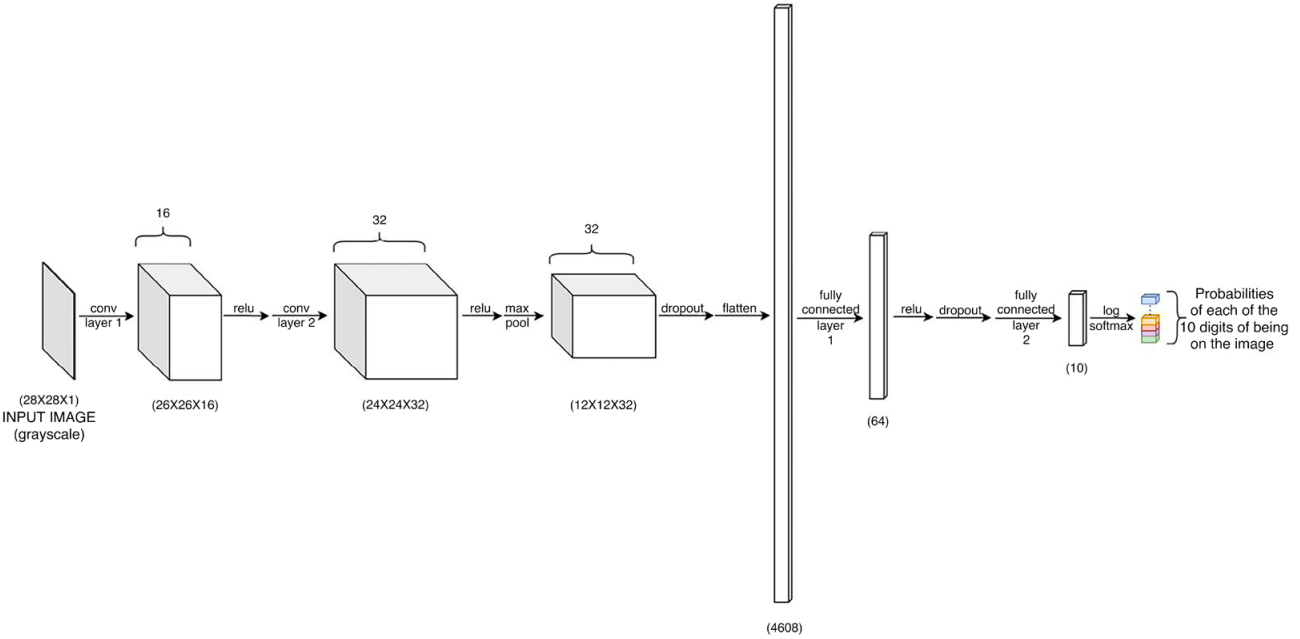

In [2]:
class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet,self).__init__()
    self.cn1 = nn.Conv2d(1,16,3,1)
    self.cn2 = nn.Conv2d(16,32,3,1)
    self.dp1 = nn.Dropout2d(0.10)
    self.dp2 = nn.Dropout2d(0.25)
    self.fc1 = nn.Linear(4608,64)
    self.fc2 = nn.Linear(64,10)
  def forward(self,x):
    x = self.cn1(x)
    x = F.relu(x)
    x = self.cn2(x)
    x = F.relu(x)
    x = F.max_pool2d(x,2)
    x = self.dp1(x)
    x = torch.flatten(x,1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dp2(x)
    x = self.fc2(x)
    op = F.log_softmax(x,dim=1)
    return op

# Defining training and inference routine

In [3]:
def train(model,device,train_dataloader,optimizer,epoch):
  model.train()
  for batch_idx,(X,y) in enumerate(train_dataloader):
    X,y = X.to(device),y.to(device)
    optim.zero_grad()
    pred_prob = model(X)
    loss = F.nll_loss(pred_prob,y)
    loss.backward()
    optim.step()
    if batch_idx % 10 == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\t \
            Loss: {:.6f}'.format(epoch, batch_idx * len(X),
                                 len(train_dataloader.dataset),
                                 100. * batch_idx / len(train_dataloader),
                                loss.item()))

In [4]:
def test(model, device, test_dataloader):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for X, y in test_dataloader:
      X, y = X.to(device), y.to(device)
      pred_prob = model(X)
      # loss summed across the batch
      test_loss += F.nll_loss(pred_prob, y, reduction='sum').item()
      # use argmax to get the most likely prediction
      pred = pred_prob.argmax(dim=1, keepdim=True)
      # count number of correct predictions
      correct += pred.eq(y.view_as(pred)).sum().item()
  test_loss /= len(test_dataloader.dataset)
  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_dataloader.dataset),
    100. * correct / len(test_dataloader.dataset)))

# Create Data Loader

In [5]:
train_dataloader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1302,), (0.3069,))
                   ])),
    # train_X.mean()/256 and train_X.std()/256
    batch_size=32, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1302,), (0.3069,))
                   ])),
    batch_size=500, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 14.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 479kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.40MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.74MB/s]


# Define Optimizer

In [6]:
# Defining the optimizer and device we will use to run the model training
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvNet().to(device)
optim = optim.Adam(model.parameters(),lr=0.05)

# Model Training

In [7]:
# Training the Model
for epoch in range(1,3):
  train(model,device,train_dataloader,optim,epoch)
  test(model,device,test_dataloader)

/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Train Epoch: 1 [0/60000 (0%)]	             Loss: 2.281588
Train Epoch: 1 [320/60000 (1%)]	             Loss: 2.366724
Train Epoch: 1 [640/60000 (1%)]	             Loss: 2.338969
Train Epoch: 1 [960/60000 (2%)]	             Loss: 2.311865
Train Epoch: 1 [1280/60000 (2%)]	             Loss: 2.313884
Train Epoch: 1 [1600/60000 (3%)]	             Loss: 2.330542
Train Epoch: 1 [1920/60000 (3%)]	             Loss: 2.353179
Train Epoch: 1 [2240/60000 (4%)]	             Loss: 2.295388
Train Epoch: 1 [2560/60000 (4%)]	             Loss: 2.306180
Train Epoch: 1 [2880/60000 (5%)]	             Loss: 2.299496
Train Epoch: 1 [3200/60000 (5%)]	             Loss: 2.275515
Train Epoch: 1 [3520/60000 (6%)]	             Loss: 2.293552
Train Epoch: 1 [3840/60000 (6%)]	             Loss: 2.328562
Train Epoch: 1 [4160/60000 (7%)]	             Loss: 2.324458
Train Epoch: 1 [4480/60000 (7%)]	             Loss: 2.271984
Train Epoch: 1 [4800/60000 (8%)]	             Loss: 2.319854
Train Epoch: 1 [5120/60000 (9%

# Model Inferencing

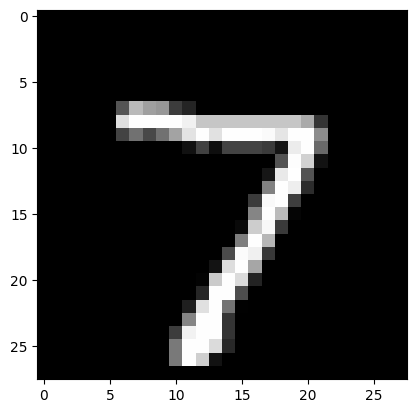

In [8]:
test_samples = enumerate(test_dataloader)
batch_idx,(X_test,y_test) = next(test_samples)
plt.imshow(X_test[0][0],cmap='gray',interpolation='none')
plt.show()

In [9]:
print(f' Model Prediction: {model(X_test.to(device)).data.max(1)[1][0]}')
print(f'Ground truth is : {y_test[0]}')

 Model Prediction: 2
Ground truth is : 7
